# Spaceship Titanic

Welcome to my solution for the **Spaceship Titanic** Kaggle competition. This notebook is a short version of the whole experiments I've done in this competition. I tried other methods (some of them just for fun), but Xgboost was the best one I found. I confess that I didn't have enough time to test different combinations of parameters. On June 19, this solution got a score of 0.80687 (201 out of 2279 participants).

In [1]:
import pandas as pd
from sklearn import clone
from sklearn.preprocessing import OrdinalEncoder
import sklearn
import numpy as np
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
import seaborn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from numpy import sort
from seaborn import pairplot
from matplotlib import pyplot as plt

# Utils

Natively, Sklearn imputers return a Numpy array with the imputed data. This wrapper allows to return a Pandas DataFrame with the original column's names and the imputed values.

In [2]:
def pandas_sklearn_imputer(sklearn_imputer):
    """
    This wrapper allows to keep dataframe info after performing imputation with a SklearnImputer
    :param sklearn_imputer: SKLearn Imputer
    :return:
    """

    class Imputer(sklearn_imputer):
        def fit(self, X, y=None):
            self.columns = X.columns
            return super().fit(X, y)

        def transform(self, X):
            return pd.DataFrame(super().transform(X), columns=self.columns)

    return Imputer

# Load Data

Start by loading the train and test data. Test data does not contain any labels and is used to predict the solution to be submitted. Train data will be later split into train and validation sets.

In [3]:
TRAIN_DATA_PATH = '../data/train.csv'
TEST_DATA_PATH = '../data/test.csv'

In [4]:
train_data = pd.read_csv(TRAIN_DATA_PATH)
train_data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [5]:
test_data = pd.read_csv(TEST_DATA_PATH)
test_data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


The bar plot below shows the distribution of the target variable. It seems that the dataset is quite balanced, which are great news!

<AxesSubplot:>

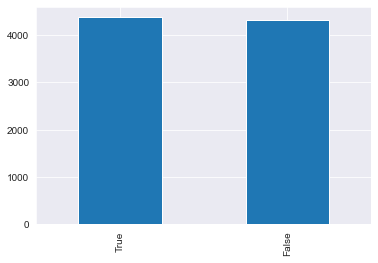

In [6]:
train_data['Transported'].value_counts().plot.bar()

# Data Preprocessing

Before we start training a model, some data preprocessing is performed. This includes:
 - Removing features that are unique or split them into multiple non-unique features
 - Converting categorical features to numeric features
 - Imputing missing values
 - Normalizing features

## Split Passenger ID

The PassengerId is a unique identifier for each passenger composed of a group ID and a passenger ID. We can split the PassengerId into two separate features:
   - GroupId: The group ID is a unique identifier for the group of passengers
   - PassengerId: The passenger ID is a unique identifier for the passenger inside the group

In [7]:
def split_passenger_id(df):
    """
    Split PassengerId into GroupId and PassengerId
    :param df: Dataframe
    :return: A new dataframe with the slit data
    """
    clean_df = df.copy()
    group_plus_id = clean_df['PassengerId'].str.split('_', expand=True)
    clean_df['GroupId'] = group_plus_id[0]
    clean_df['PassId'] = group_plus_id[1]

    return clean_df

## Split Cabin

The Cabin feature contains a lot of information about the cabin. We can split the feature into several features:
   - Cabin: The cabin number
   - Num: The number of the cabin
   - Side: The side of the cabin

In [8]:
def split_cabin(df):
    """
    Split Cabin into Cabin, Num and Side
    :param df:
    :return:
    """
    clean_df = df.copy()
    group_plus_id = clean_df['Cabin'].str.split('/', expand=True)
    clean_df['Deck'] = group_plus_id[0]
    clean_df['Num'] = group_plus_id[1]
    clean_df['Side'] = group_plus_id[2]

    return clean_df

## Encode Categorical Data

In [9]:
def encode_categorical_labels(df):
    """
    Encode categorical labels into ordinal or one-hot encoded representation.
    :param df:
    :return:
    """
    ordinal_encoder = OrdinalEncoder()
    # Convert boolean variables to numeric (0,1)
    df['CryoSleep'] = ordinal_encoder.fit_transform(df['CryoSleep'].values.reshape(-1, 1))
    df['VIP'] = ordinal_encoder.fit_transform(df['VIP'].values.reshape(-1, 1))

    # Deck and Side are categorical variables, but somehow we can consider that contiguous categories are spatially close to each other. For instance, Deck A is next to Deck B. In it, they are not one-hot encoded.
    df['Deck'] = ordinal_encoder.fit_transform(df['Deck'].values.reshape(-1, 1))
    df['Side'] = ordinal_encoder.fit_transform(df['Side'].values.reshape(-1, 1))

    # One-hot encode HomePlanet and Destination
    df = pd.concat([df, pd.get_dummies(df['HomePlanet'], prefix='HomePlanet')], axis=1).astype('int', errors='ignore')
    df = pd.concat([df, pd.get_dummies(df['Destination'], prefix='Destination')], axis=1).astype('int', errors='ignore')

    # Make sure that categorical variables are integers
    df['VIP'] = df['VIP'].astype('int', errors='ignore')
    df['CryoSleep'] = df['CryoSleep'].astype('int', errors='ignore')
    df['Deck'] = df['Deck'].astype('int', errors='ignore')
    df['Side'] = df['Side'].astype('int', errors='ignore')
    df['GroupId'] = df['GroupId'].astype('int', errors='ignore')

    return df


## Remove Unused Columns

In [10]:
def remove_unused_columns(df):
  #clean_df = df.drop(columns=['HomePlanet', 'Destination', 'Cabin', 'PassengerId', 'Name', 'FamilyName'])
  clean_df = df.drop(columns=['HomePlanet', 'Destination', 'Cabin', 'PassengerId', 'Name', 'FamilyName'])

  return clean_df

## Extract Gender

In [11]:
def extract_family_name(df):
    df_with_gender = df.copy()
    df_with_gender['FamilyName'] = df_with_gender['Name']
    df_with_gender['FamilyName'].fillna('Unknown Unknown', inplace=True)
    df_with_gender['FamilyName'] = df_with_gender['FamilyName'].apply(lambda x: x.split(' ')[1])

    return df_with_gender

Now that a set of procedures are defined, we encapsulate the pre-processing logic into the `SpaceshipTitanicDataPreprocessor` class. This is particularly useful when we want to learn the data imputer and data scaler from the training data, and then use them to preprocess the test data.

In [12]:
from sklearn.impute import KNNImputer


class SpaceshipTitanicDataPreprocessor:
    raw_categorical_columns = ['CryoSleep', 'VIP', 'GroupId', 'Side', 'HomePlanet', 'Destination']
    numerical_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Num']
    categorical_columns = ['GroupId', 'PassId', 'VIP', 'CryoSleep', 'Side', 'Deck']

    def __init__(self):
        self.imputer_class = pandas_sklearn_imputer(KNNImputer)
        self.data_imputer = self.imputer_class(n_neighbors=4, weights="uniform")
        self.scaler = StandardScaler()

    def prepare_data(self, df):
        """
        Apply a set of pre-processing steps to the data (both training, validation and test data).
        :param df:
        :return:
        """
        # Split passenger id into group id and passenger id
        clean_df = split_passenger_id(df)
        # Split cabin into cabin, number and side
        clean_df = split_cabin(clean_df)

        # Extract family name
        clean_df = extract_family_name(clean_df)

        # Ensure that missing values are represented as Numpy NaN
        clean_df[self.raw_categorical_columns] = clean_df[self.raw_categorical_columns].replace([np.nan, 'nan', 'NaN'],
                                                                                                        np.nan)
        # Encode categorical variables
        clean_df = encode_categorical_labels(clean_df)
        # Remove unused columns
        clean_df = remove_unused_columns(clean_df)
        # Convert categorical features to integers
        clean_df[self.categorical_columns] = clean_df[self.categorical_columns].astype('int', errors="ignore")

        return clean_df

    def preprocess_train_data(self, df):
        """
        Apply the pre-processing steps to the training data. This includes learning the imputer and scaler, and then applying them to the training data. The imputer and scaler are then stored and can be later used to preprocess the test data.
        :param df:
        :return:
        """
        processed_df = df.copy()
        processed_df = self.prepare_data(processed_df.drop(columns=['Transported']))

        # Learn the imputer for numerical columns
        processed_df[self.numerical_columns] = self.data_imputer.fit_transform(processed_df[self.numerical_columns])

        # Learn the scaler for numerical columns
        self.scaler.fit(processed_df[self.numerical_columns])
        # Apply the scaler to the numerical columns
        processed_df[self.numerical_columns] = pd.DataFrame(self.scaler.transform(processed_df[self.numerical_columns]), columns=self.numerical_columns)

        # Drop unused columns. The passenger id is an unique identifier, so it is not useful for training.
        processed_df = processed_df.drop(columns=['PassId'])

        return processed_df

    def preprocess_test_data(self, df):
        """
        This method is similar to `preprocess_train_data`, but it does not learn the imputer and scaler. Instead, it uses the imputer and scaler that were learned from the training data.
        :param df:
        :return:
        """
        processed_df = df.copy()
        processed_df = self.prepare_data(processed_df)

        processed_df[self.numerical_columns] = self.data_imputer.transform(processed_df[self.numerical_columns])
        processed_df[self.numerical_columns] = pd.DataFrame(self.scaler.transform(processed_df[self.numerical_columns]), columns=self.numerical_columns)
        processed_df = processed_df.drop(columns=['PassId'])
        return processed_df

The previously defined `SpaceshipTitanicDataPreprocessor` class can be used to preprocess the training and test data. We save it to `final_train_data_X` and `final_test_data` variables.

In [13]:
# Initialize the preprocessor
data_processor = SpaceshipTitanicDataPreprocessor()
# Save training data labels
final_train_data_y = train_data['Transported']
# Process training data
final_train_data_X = data_processor.preprocess_train_data(train_data)
# Process test data
final_test_data = data_processor.preprocess_test_data(test_data)
final_train_data_X

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupId,Deck,Num,Side,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0.0,0.709471,0.0,-0.338272,-0.283514,-0.287503,-0.273723,-0.266086,1,1.0,-1.182773,0.0,0,1,0,0,0,1
1,0.0,-0.333917,0.0,-0.173494,-0.277880,-0.245762,0.213706,-0.227338,2,5.0,-1.182773,1.0,1,0,0,0,0,1
2,0.0,2.031096,1.0,-0.273268,1.954868,-0.287503,5.688189,-0.222935,3,0.0,-1.182773,1.0,0,1,0,0,0,1
3,0.0,0.292116,0.0,-0.338272,0.519575,0.331925,2.681929,-0.096125,3,0.0,-1.182773,1.0,0,1,0,0,0,1
4,0.0,-0.890390,0.0,0.119779,-0.239698,-0.035391,0.227912,-0.264324,4,5.0,-1.180802,1.0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.0,0.848589,1.0,-0.338272,3.984810,-0.287503,1.185014,-0.200919,9276,0.0,-0.989634,0.0,0,1,0,1,0,0
8689,1.0,-0.751272,0.0,-0.338272,-0.283514,-0.287503,-0.273723,-0.266086,9278,6.0,1.771459,1.0,1,0,0,0,1,0
8690,0.0,-0.194799,0.0,-0.338272,-0.283514,2.838018,-0.272835,-0.266086,9279,6.0,1.773430,1.0,1,0,0,0,0,1
8691,0.0,0.222557,0.0,-0.338272,0.373103,-0.287503,0.039688,2.582744,9280,4.0,0.015475,1.0,0,1,0,1,0,0


The data is already pre-processed and is going to be split into train and validation sets

In [14]:
# Split the labeled data into train and validation sets
train_x, val_x, train_y, val_y = sklearn.model_selection.train_test_split(final_train_data_X, final_train_data_y, test_size=0.2, random_state=100)

# Feature Selection

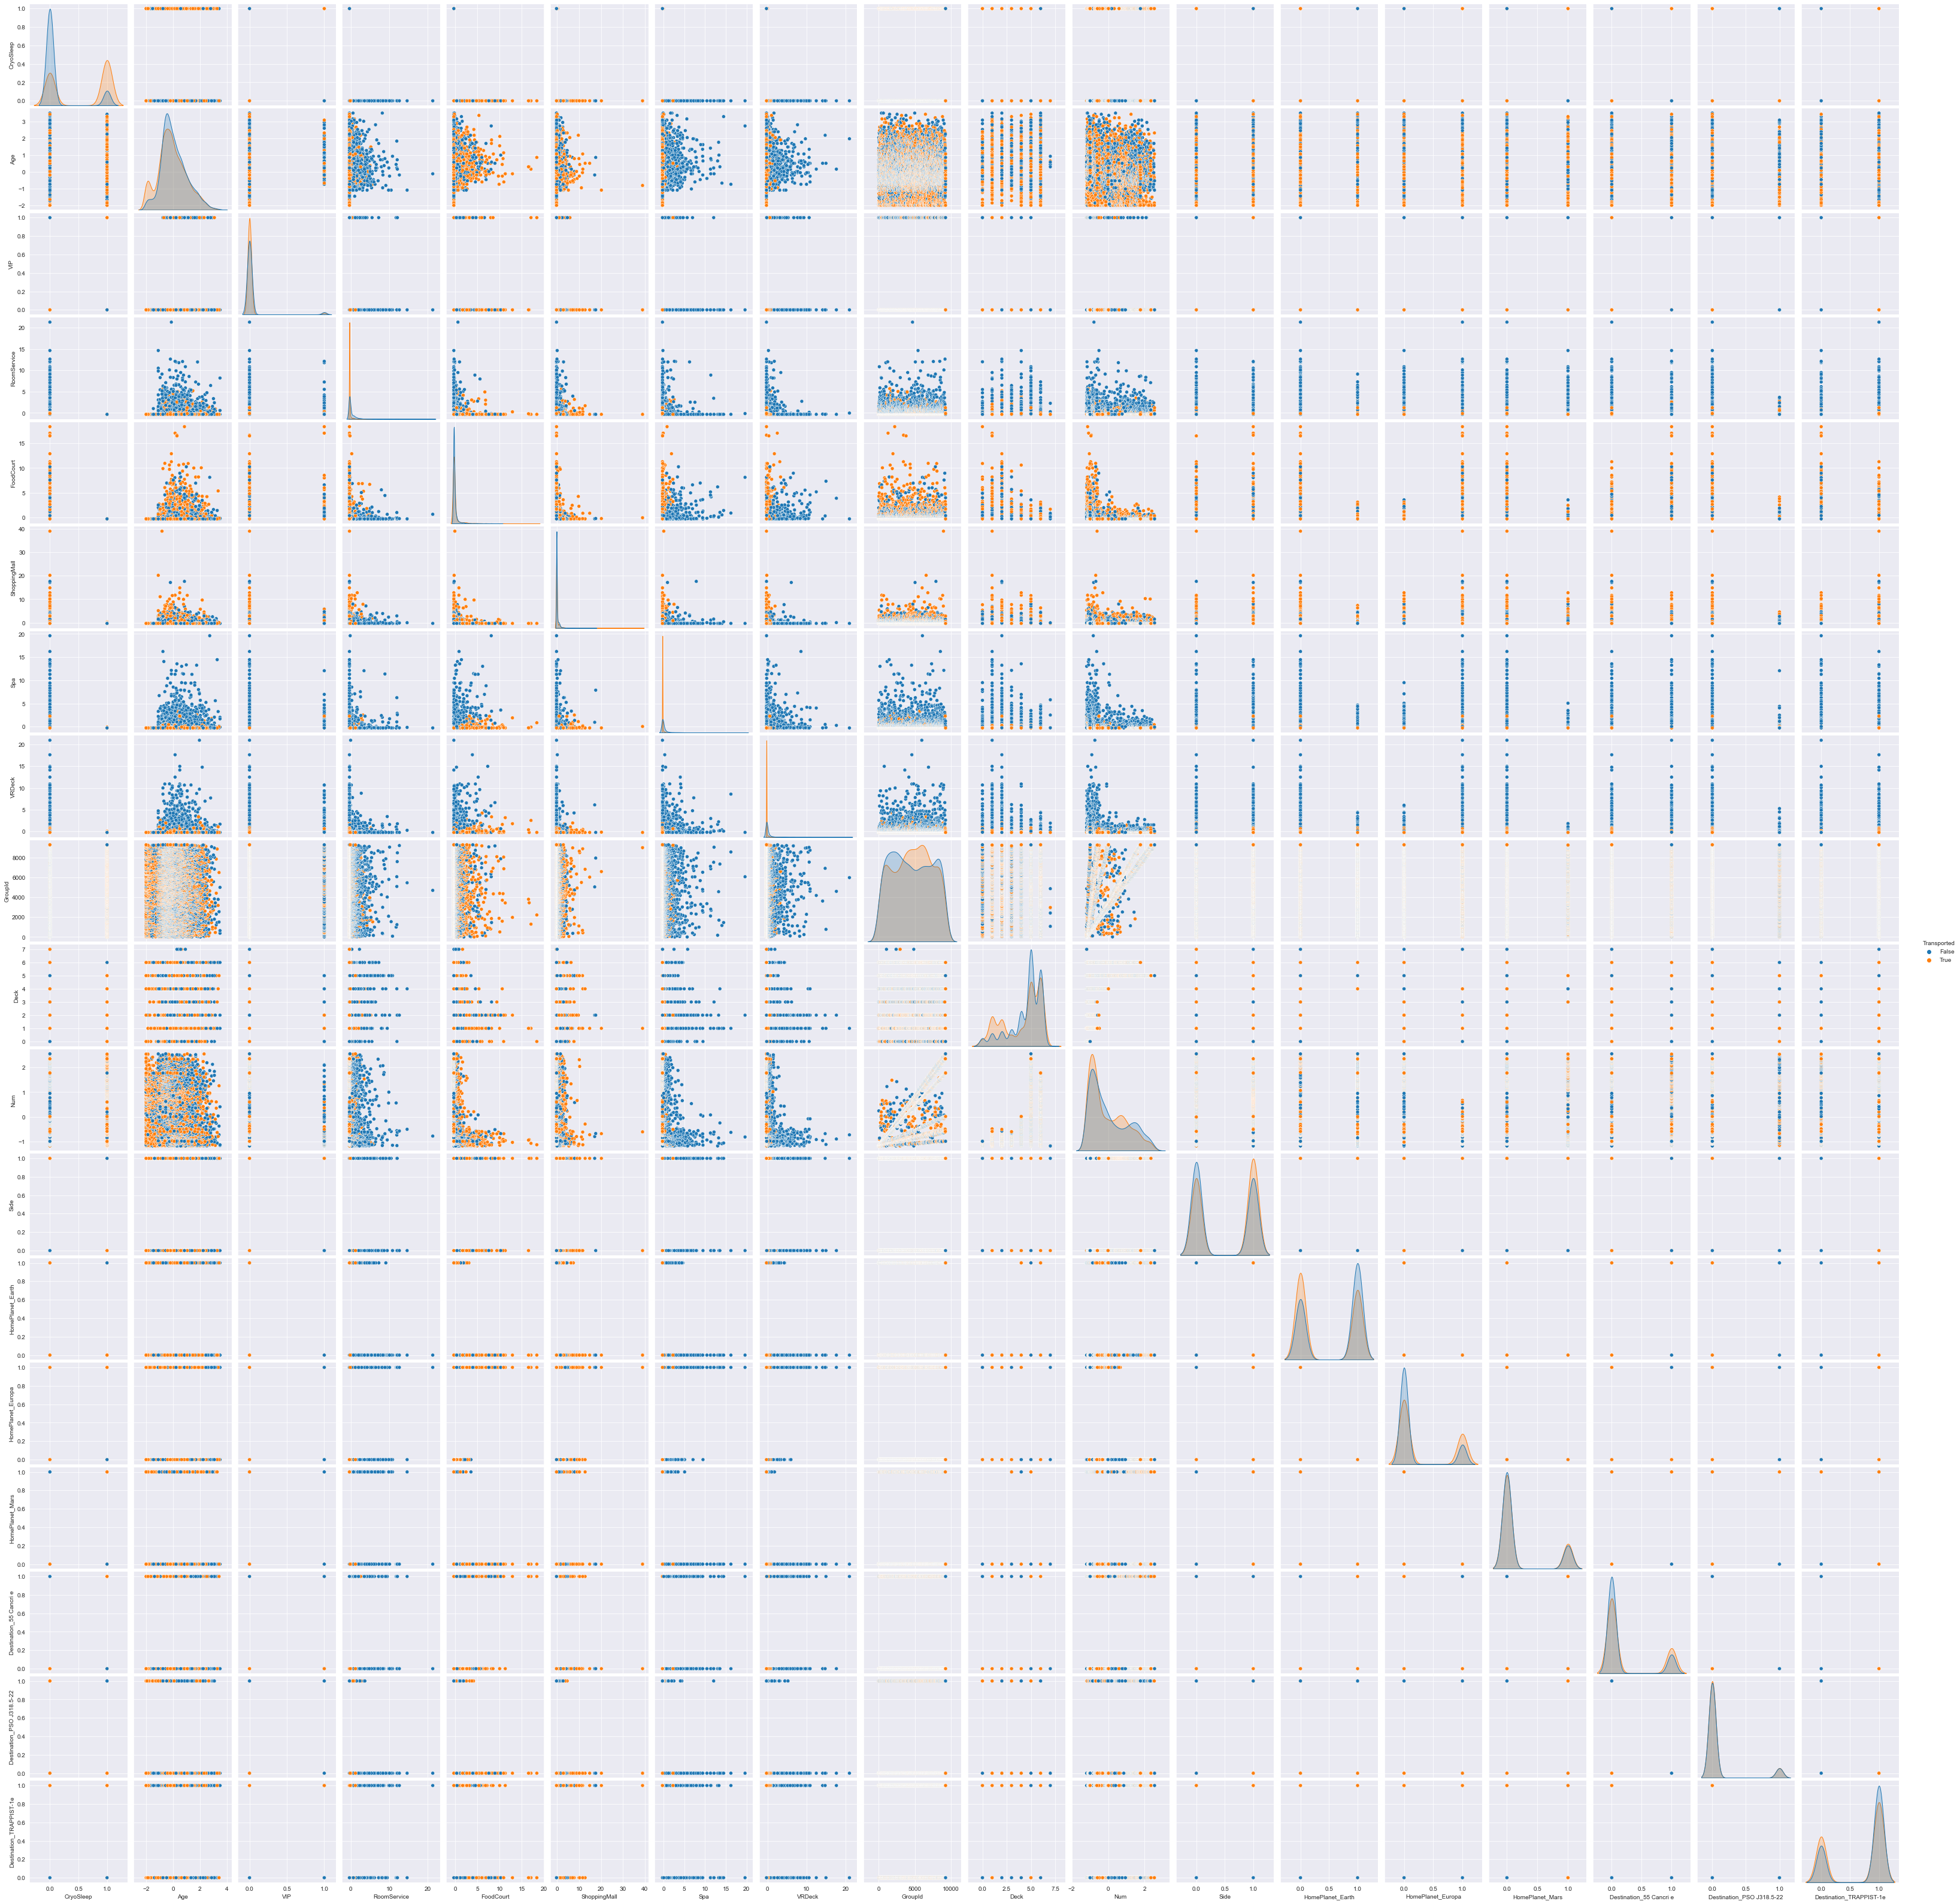

In [15]:
pairplot(final_train_data_X.join(final_train_data_y), hue="Transported")

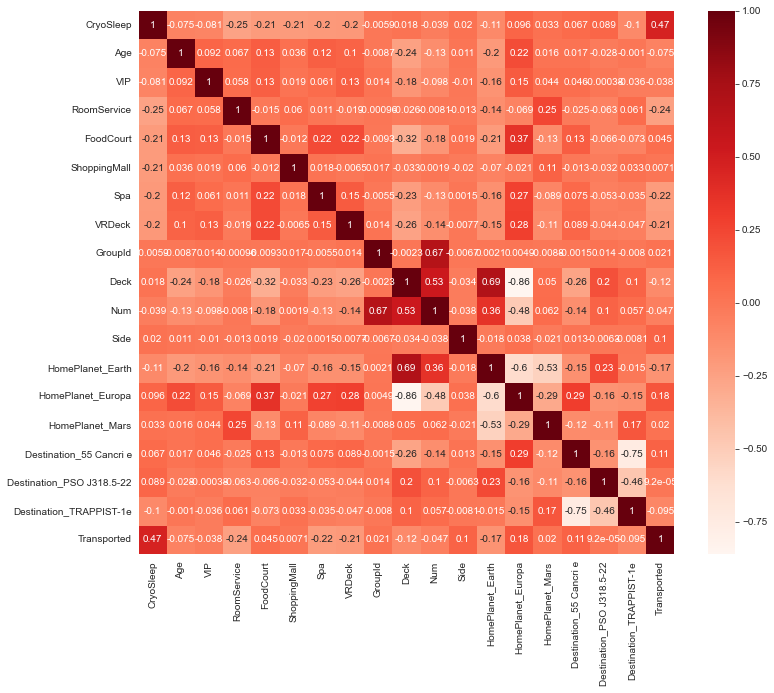

In [16]:
plt.figure(figsize=(12,10))
cor = final_train_data_X.join(final_train_data_y).corr()
seaborn.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Apart from some *adhoc* feature selection and engineering, I tried to filter out the features that are not useful for the model. The `selected_highest_accuracy_features` uses the feature importances from a given estimator to select the features that lead to the highest accuracy.

In [17]:
import warnings
warnings.filterwarnings('ignore')

def select_most_important_features(estimator, feature_importances, t_x, t_y, v_x, v_y, test_x):
    """
    Uses the feature importances from a given estimator to select the features that lead to the highest accuracy.
    :param estimator: An already trained estimator.
    :param feature_importances: A list of feature importance.
    :param t_x: Training data features.
    :param t_y: Training data labels.
    :param v_x: Validation data features.
    :param v_y: Validation data labels.
    :param test_x: Test data features.
    :return: The training, validation and test data with the selected features.
    """
    thresholds = sort(feature_importances)

    max_accuracy = -1.0
    best_threshold = None

    for thresh in thresholds:
        # Select features using threshold
        selection = SelectFromModel(estimator, threshold=thresh, prefit=True)
        select_X_train = selection.transform(t_x)
        # Train model
        selection_model = clone(estimator)
        selection_model.fit(select_X_train, t_y)
        # Eval model
        select_X_val = selection.transform(v_x)
        y_pred = selection_model.predict(select_X_val)
        accuracy = accuracy_score(v_y, y_pred)

        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_threshold = thresh

        print("Threshold=%.3f, Number of Features=%.5d, Accuracy: %.5f" % (thresh, select_X_train.shape[1], accuracy))

    print("Best Threshold: ", best_threshold)

    selection = SelectFromModel(estimator, threshold=best_threshold, prefit=True)
    return selection.transform(t_x), selection.transform(v_x), selection.transform(test_x)

# XGBoost

Apart from the XGBoost, I tried SKLearn Random Forest and Pytorch Neural Networks (just for fun!), but (as expected?) XGBoost outperforms them all for this dataset.

In [18]:
# A set of possible parameters for the XGBoost model. We use random search to find the best parameters.
XGB_PARAM_GRID = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
}

In [19]:
# The default parameters for the stratified k-fold cross-validation.
STRATIFIED_K_FOLD_PARAMS = {
    'n_splits': 10,
    'random_state': 7,
}

Stratified K-Fold cross validation is used to evaluate the model by splitting the data into k folds, each with approximately the same percentage of samples of each target class.

In [20]:
cv = StratifiedKFold(**STRATIFIED_K_FOLD_PARAMS, shuffle=True)

In [21]:
xgb_cl = XGBClassifier(learning_rate=0.02, n_estimators=1000, objective='binary:logistic', nthread=1)

random_search = RandomizedSearchCV(xgb_cl, param_distributions=XGB_PARAM_GRID, n_iter=5, scoring='accuracy', n_jobs=-1, cv=cv, verbose=3, random_state=1001)
random_search.fit(train_x, train_y)


Fitting 10 folds for each of 5 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=7, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           intera...
                                           monotone_constraints=None,
                                           n_estimators=1000, n_jobs=None,
                                           nthread=1, num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=1001, scoring='accuracy', verbose=3)

## Feature Selection

Now that the best parameters are found, we can use the resulting feature importances to select the features that optimize the accuracy.

In [22]:
filtered_train_x, filtered_val_x, filtered_test_x = select_most_important_features(random_search.best_estimator_, random_search.best_estimator_.feature_importances_, train_x, train_y, val_x, val_y, final_test_data)

Threshold=0.012, Number of Features=00018, Accuracy: 0.80966
Threshold=0.012, Number of Features=00017, Accuracy: 0.80736
Threshold=0.014, Number of Features=00016, Accuracy: 0.81081
Threshold=0.015, Number of Features=00015, Accuracy: 0.81081
Threshold=0.019, Number of Features=00014, Accuracy: 0.80679
Threshold=0.021, Number of Features=00013, Accuracy: 0.80851
Threshold=0.022, Number of Features=00012, Accuracy: 0.79643
Threshold=0.022, Number of Features=00011, Accuracy: 0.79816
Threshold=0.028, Number of Features=00010, Accuracy: 0.79586
Threshold=0.030, Number of Features=00009, Accuracy: 0.79988
Threshold=0.034, Number of Features=00008, Accuracy: 0.79643
Threshold=0.035, Number of Features=00007, Accuracy: 0.79356
Threshold=0.045, Number of Features=00006, Accuracy: 0.78838
Threshold=0.051, Number of Features=00005, Accuracy: 0.75733
Threshold=0.066, Number of Features=00004, Accuracy: 0.73663
Threshold=0.072, Number of Features=00003, Accuracy: 0.72685
Threshold=0.129, Number 

The best features are selected, and we can use them to train the model.

In [23]:
best_xgb_cl = clone(random_search.best_estimator_)
best_xgb_cl.fit(filtered_train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=5, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=1, nthread=1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, ...)

## Validation

Before cross-validation, we can directly evaluate the model on the validation set.

In [24]:
results = best_xgb_cl.predict(filtered_val_x)
accuracy_score(val_y, results)

0.8108108108108109

Now we can use the cross-validation to evaluate the model. Instead of using the training set, we join the training and validation sets and use them to for cross-validation, which in turn increases the dataset size.

In [28]:
from sklearn.model_selection import cross_val_score

results = cross_val_score(random_search.best_estimator_, np.concatenate([filtered_train_x, filtered_val_x]), np.concatenate([train_y, val_y]), cv=cv)
print(f'Accuracy: {results.mean()} ({results.std()})')

Accuracy: 0.8057025514860522 (0.008925268695596265)


Before predicting the labels for the test set, we re-train the model using the whole dataset.

In [26]:
all_data_model = best_xgb_cl.fit(np.concatenate([filtered_train_x, filtered_val_x]), np.concatenate([train_y, val_y]))

Finally, we can predict the labels for the test set and generate the submission file.

In [27]:
results = best_xgb_cl.predict(filtered_test_x)
submission_results = pd.concat([test_data['PassengerId'], pd.DataFrame({'Transported': results.astype(bool)})], axis=1)
submission_results.to_csv('../submission.csv', index=False)